In [1]:
import os
import sys
import numpy as np
import numpy.typing as npt
from typing import List, Tuple
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import python_modules.Server as Server

In [2]:
class LowHighDemoSDE():
    _rng: np.random.Generator
    
    def __init__(self, rng: np.random.Generator):
        self._rng = rng
        pass
    
    def get_order_count(self, t: float, dt: float) -> int:
        return int(15 * self._unadjusted_volatility(t) + 5)
    
    def _adjustment_factor(self, order_count: int) -> float:
        return np.sqrt(order_count)
    
    def _unadjusted_volatility(self, t: float) -> float:
        if 0.8 <= t:
            return 0.025
        elif 0.4 <= t <= 0.6:
            return 1.0
        else:
            return 0.2
    
    def get_volatility(self, t: float, dt: float) -> float:
        return 3.0 * self._adjustment_factor(self.get_order_count(t, dt)) * self._unadjusted_volatility(t)
    
    def _unadjusted_reversion(self, t: float) -> float:
        if 0.8 <= t:
            return 30.0
        elif 0.5 <= t:
            return self._unadjusted_volatility(t) * (5.0 + 30 * t)
        else:
            return self._unadjusted_volatility(t) * 5.0
    
    def _get_reversion(self, t: float, dt: float) -> float:
        return self._adjustment_factor(self.get_order_count(t, dt)) * self._unadjusted_reversion(t)
    
    def get_spread(self, t: float, dt: float) -> float:
        return 0.04
    
    def get_stock_price(self, t: float, dt: float) -> float:
        if 0.5 <= t:
            return 110.0
        else:
            return 100.0
    
    def generate_bid_price_array(self, price: float, t: float, dt: float) -> npt.NDArray[np.float64]:
        order_count = self.get_order_count(t, dt)
        half_spread = self.get_spread(t, dt) / 2.0
        target = self.get_stock_price(t, dt)
        volatility = self.get_volatility(t, dt)
        reversion = self._get_reversion(t, dt)
        
        return price - half_spread \
               + reversion * (target - price) * dt \
               + volatility * np.sqrt(price * dt) \
               * self._rng.normal(loc=0.0, scale=1.0, size=order_count)
    
    def generate_ask_price_array(self, price: float, t: float, dt: float) -> npt.NDArray[np.float64]:
        order_count = self.get_order_count(t, dt)
        half_spread = self.get_spread(t, dt) / 2.0
        target = self.get_stock_price(t, dt)
        volatility = self.get_volatility(t, dt)
        reversion = self._get_reversion(t, dt)
        
        return price + half_spread \
               + reversion * (target - price) * dt \
               + volatility * np.sqrt(price * dt) \
               * self._rng.normal(loc=0.0, scale=1.0, size=order_count)
    pass

In [3]:
class SecurityStock(Server.ISecurity):
    def __init__(self, name):
        super().__init__()
        self.name = name

    def is_tradeable(self):
        return True

    def before_step(self, simulation, pm):
        pass

    def after_step(self, simulation, pm):
        pass

    def on_simulation_start(self, simulation, pm):
        pass

    def on_simulation_end(self, simulation, pm):
        pass

    def on_trade_executed(self, simulation, pm, buyer_id, seller_id, price, volume):
        pass


In [4]:
security_stock = SecurityStock("STOCK")

ticker_to_security = {
    "STOCK": security_stock
}

simulation = Server.GenericSimulation(ticker_to_security, 1.0, 1000)
STOCK_ID = simulation.get_security_id("STOCK")

In [5]:
user_ANON = simulation.add_user("ANON")

In [6]:
rng = np.random.default_rng(42)
SDE = LowHighDemoSDE(rng)
ORDER_SIZE_MIN = 1
ORDER_SIZE_MAX = 5
REMOVAL_PERCENTAGE = 0.10
results = []
while True:
    current_step = simulation.get_tick()
    t = simulation.get_t()
    dt = simulation.get_dt()
    ORDER_COUNT = SDE.get_order_count(t, dt)
    
    if current_step == 0:
        price_distribution = rng.uniform(0.75, 1.0, size=ORDER_COUNT)
        volume_distribution = rng.integers(ORDER_SIZE_MIN, ORDER_SIZE_MAX, ORDER_COUNT)
        target = SDE.get_stock_price(t, dt)
        volatility = SDE.get_volatility(t, dt)
        SPREAD = SDE.get_spread(t, dt)
        HALF_SPREAD = SPREAD / 2

        bid_top_price = round(target - HALF_SPREAD, 2)
        bid_bottom_price = round(bid_top_price - 0.5 * volatility * bid_top_price, 2)
        bid_prices: List[float] = list(bid_top_price * price_distribution + bid_bottom_price * (1.0 - price_distribution))
        bids = [(Server.OrderSide.BID, price, volume_distribution[i]) for i, price in enumerate(bid_prices)]
        
        ask_bottom_price = round(target + HALF_SPREAD, 2)
        ask_top_price = round(ask_bottom_price + 0.5 * volatility * ask_bottom_price, 2)
        ask_prices: List[float] = list(ask_bottom_price * price_distribution + ask_top_price * (1.0 - price_distribution))
        asks = [(Server.OrderSide.ASK, price, volume_distribution[i]) for i, price in enumerate(ask_prices)]

        combined_orders: List[Tuple[Server.OrderSide, float, float]] = bids + asks
        rng.shuffle(combined_orders)

        for (side, price, volume) in combined_orders:
            simulation.submit_limit_order(user_ANON, STOCK_ID, side, round(price, 2), volume)
            pass
        pass
    else:
        orders_ANON = list(simulation.get_all_open_user_orders(user_ANON, STOCK_ID))
        
        # remove some percent of ANON orders
        if (k := int(len(orders_ANON) * REMOVAL_PERCENTAGE)) > 0:
            orders_to_remove = list(rng.choice(a=orders_ANON, size=k, replace=False))
            for order_id in orders_to_remove:
                simulation.submit_cancel_order(user_ANON, STOCK_ID, order_id)
                pass
            pass
        
        top_bid = simulation.get_top_bid(STOCK_ID)
        top_ask = simulation.get_top_ask(STOCK_ID)
        
        top_bid_price = top_bid.price
        top_ask_price = top_ask.price
        
        bid_prices = SDE.generate_bid_price_array(top_bid_price, t, dt)
        bid_quantities = rng.integers(ORDER_SIZE_MIN, ORDER_SIZE_MAX, size=ORDER_COUNT)
        bids = [(Server.OrderSide.BID, price, bid_quantities[i]) for i, price in enumerate(bid_prices)]
        
        ask_prices = SDE.generate_ask_price_array(top_ask_price, t, dt)
        ask_quantities = rng.integers(ORDER_SIZE_MIN, ORDER_SIZE_MAX, size=ORDER_COUNT) 
        asks = [(Server.OrderSide.ASK, price, ask_quantities[i]) for i, price in enumerate(ask_prices)]
        
        combined_orders: List[Tuple[Server.OrderSide, float, float]] = bids + asks
        rng.shuffle(combined_orders)

        for (side, price, volume) in combined_orders:
            simulation.submit_limit_order(user_ANON, STOCK_ID, side, round(price, 2), volume)
            pass
        pass
    
    step_results = simulation.do_simulation_step()
    results.append(step_results)
    if not step_results.has_next_step:
        break
    
    pass

In [7]:
depth_frames = []

for result in results:
    bid_depth, ask_depth = result.order_book_depth_per_security["STOCK"]
    depth_frames.append((bid_depth, ask_depth))

In [8]:
def animate_order_book_with_metrics(depth_frames, transactions_per_tick, interval_ms=500):
    """
    depth_frames: List of tuples (bid_depth: dict, ask_depth: dict)
    transactions_per_tick: List of list of transactions per tick. Each transaction should have `.price` and `.volume`
    """
    num_frames = len(depth_frames)

    figure_size = (8, 14)
    num_subplots = 4
    fig, axes = plt.subplots(num_subplots, 1, figsize=figure_size, gridspec_kw={'height_ratios': [3] + [1] * (num_subplots - 1)})
    ax_depth, ax_price, ax_volume, ax_volatility = axes
    
    ax_depth.set_ylabel("Cumulative Volume")
    ax_depth.set_title("Order Book Depth")
    ax_price.set_ylabel("Midpoint Price")
    ax_price.set_title("Stock Market Midpoint")
    ax_volume.set_ylabel("Transacted Quantity")
    ax_volume.set_title("Transaction Volume")
    ax_volatility.set_ylabel("Rolling Volatility")
    ax_volatility.set_title("Rolling 10-Frame Volatility")

    # Precompute midprices and transaction volumes
    midpoint_prices = []
    transaction_volumes = []
    rolling_volatility = []
    
    def compute_volatility(prices, window=10):
        if len(prices) < window:
            return 0
        return np.std(prices[-window:])

    for i in range(num_frames):
        bid_depth, ask_depth = depth_frames[i]

        best_bid = max(bid_depth.keys(), default=np.nan)
        best_ask = min(ask_depth.keys(), default=np.nan)

        mid = (best_bid + best_ask) / 2 if not np.isnan(best_bid) and not np.isnan(best_ask) else np.nan
        midpoint_prices.append(mid)

        txs = transactions_per_tick[i]
        vol = sum(tx.volume for tx in txs)
        transaction_volumes.append(vol)
        rolling_volatility.append(compute_volatility(midpoint_prices))
        pass

    def update(frame):
        ax_depth.clear()
        ax_price.clear()
        ax_volume.clear()
        ax_volatility.clear()

        bid_depth, ask_depth = depth_frames[frame]
        bid_prices = sorted(bid_depth.keys())
        bid_volumes = [bid_depth[p] for p in bid_prices]

        ask_prices = sorted(ask_depth.keys())
        ask_volumes = [ask_depth[p] for p in ask_prices]

        # Depth chart
        ax_depth.fill_between(bid_prices, bid_volumes, color='green', alpha=0.5)
        ax_depth.fill_between(ask_prices, ask_volumes, color='red', alpha=0.5)
        ax_depth.set_xlim(min(min(bid_prices), min(ask_prices)), max(max(bid_prices), max(ask_prices)))
        ax_depth.set_ylim(0, max(bid_volumes + ask_volumes, default=50))
        ax_depth.set_title(f"Order Book Depth (Tick {frame})")

        # Midpoint price
        ax_price.plot(midpoint_prices[:frame + 1], color='blue')
        ax_price.set_ylabel("Mid Price")

        # Volume per tick
        ax_volume.plot(transaction_volumes[:frame + 1], color='purple')
        ax_volume.set_ylabel("Volume")

        # Rolling volatility
        ax_volatility.plot(rolling_volatility[:frame + 1], color='orange')
        ax_volatility.set_ylabel("Rolling Volatility")
        ax_volatility.set_xlabel("Tick")

    ani = FuncAnimation(fig, update, frames=num_frames, interval=interval_ms)
    ani.save("sde_simulation.mp4", writer="ffmpeg", fps=30)
    plt.tight_layout()
    plt.show()

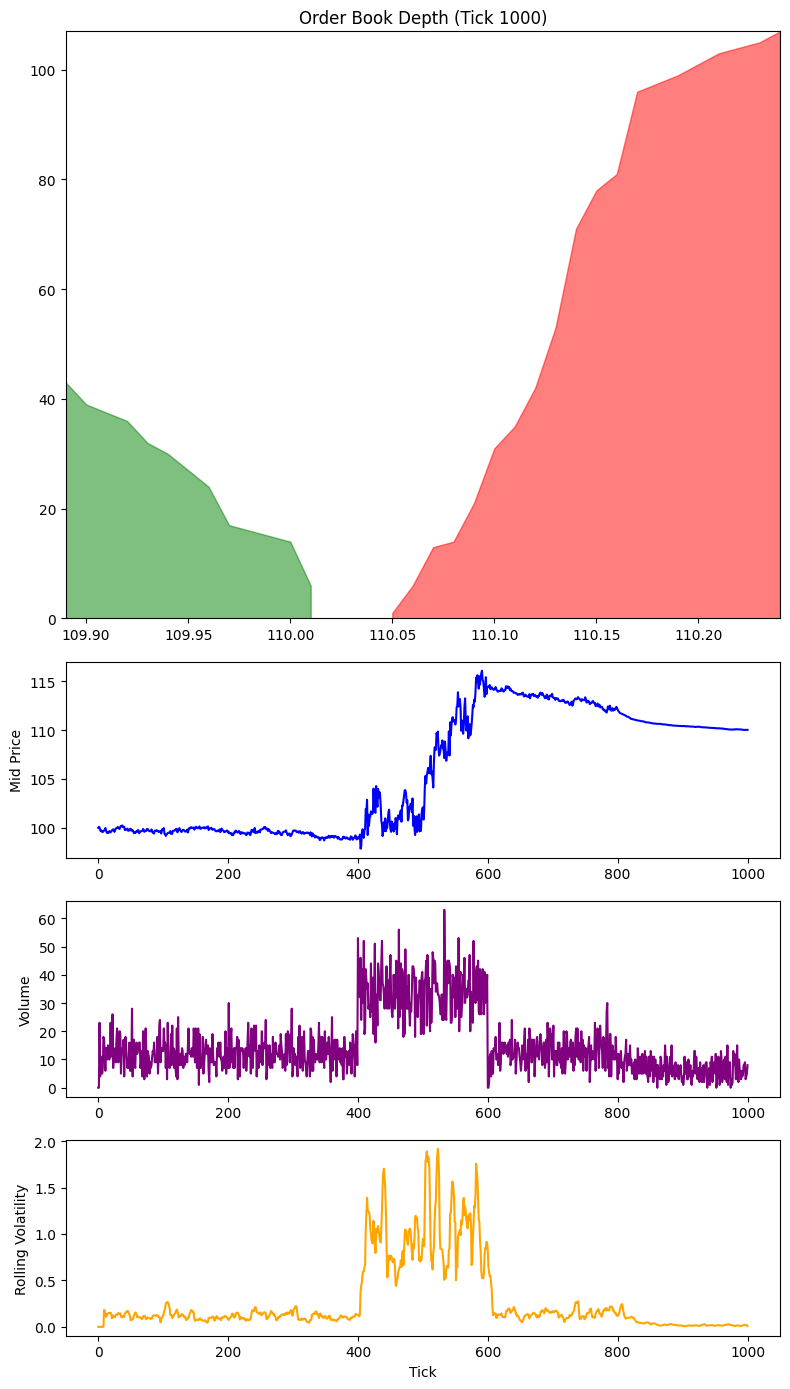

In [9]:
depth_frames = [r.order_book_depth_per_security["STOCK"] for r in results]
transactions_per_tick = [r.transactions["STOCK"] for r in results]

animate_order_book_with_metrics(depth_frames, transactions_per_tick)